# 5.3 多输入通道和多输出通道

彩色图像在高和宽2个维度外还有RGB（红、绿、蓝）3个颜色通道。假设彩色图像的高和宽分别是$h$和$w$（像素），那么它可以表示为一个$3×h×w$的多维数组。我们将大小为3的这一维称为通道（channel）维。

## 5.3.1 多输入通道

当输入数据含多个通道时，我们需要构造一个输入通道数与输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算。假设输入数据的通道数为$c_i$，那么卷积核的输入通道数同样为$c_i$。设卷积核窗口形状为$k_h×k_w$。当$c_i=1$时，我们知道卷积核只包含一个形状为$k_h×k_w$的二维数组。当$c_i>1$时，我们将会为每个输入通道各分配一个形状为$k_h×k_w$的核数组。把这$c_i$个数组在输入通道维上连结，即得到一个形状为$c_i×k_h×k_w$的卷积核。由于输入和卷积核各有$c_i$个通道，我们可以在各个通道上对输入的二维数组和卷积核的二维核数组做互相关运算，再将这$c_i$个互相关运算的二维输出按通道相加，得到一个二维数组。这就是含多个通道的输入数据与多输入通道的卷积核做二维互相关运算的输出。

图5.4展示了含2个输入通道的二维互相关计算的例子。在每个通道上，二维输入数组与二维核数组做互相关运算，再按通道相加即得到输出。图5.4中阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：(1×1+2×2+4×3+5×4)+(0×0+1×1+3×2+4×3)=56。


<font color='red'>如图所示，每个输入通道有对应的卷积核，但输出通道只有一个。</font>

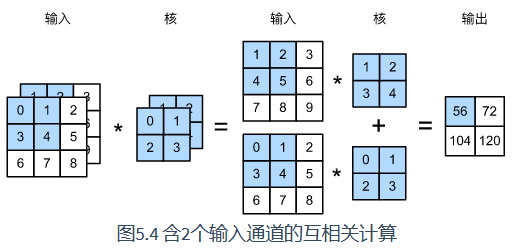

In [7]:
#含多个通道的互相关运算，只需对每个通道做互相关运算，
# 然后通过add_n函数进行累加

import torch
from torch import nn
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

def corr2d_multi_in(X,K):
    #沿着X和K的第0维（通道维）分别计算再相加
    res=d2l.corr2d(X[0,:,:],K[0,:,:])
#     print(X[0,:,:])
    for i in range(1,X.shape[0]):#X.shape[0]指的是通道数
        res+=d2l.corr2d(X[i,:,:],K[i,:,:])
    return res 

In [11]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])#输入
print(X.shape)

K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])#卷积核
print(K.shape)
corr2d_multi_in(X, K)

torch.Size([2, 3, 3])
torch.Size([2, 2, 2])


tensor([[ 56.,  72.],
        [104., 120.]])

## 5.3.2 多输出通道

当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数是多少，输出通道数总是为1。设卷积核输入通道数和输出通道数分别为$c_i$和$c_o$，高和宽分别为$k_h$和$k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为$c_i×k_h×k_w$的核数组。将它们在输出通道维上连结，卷积核的形状即$c_o×c_i×k_h×k_w$。在做互相关运算时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。

<font color='red'>要想有多个输出通道，即对每个输出通道进行扩展，每个输出通道对应多个卷积核。也就是说，要想有多个输出通道，卷积核的数量就有多少个。卷积过程中，输入层有多少个通道，滤波器就要有多少个通道，但是滤波器的数量是任意的，滤波器的数量决定了卷积后 featuremap 的通道数（与result区别）。</font>

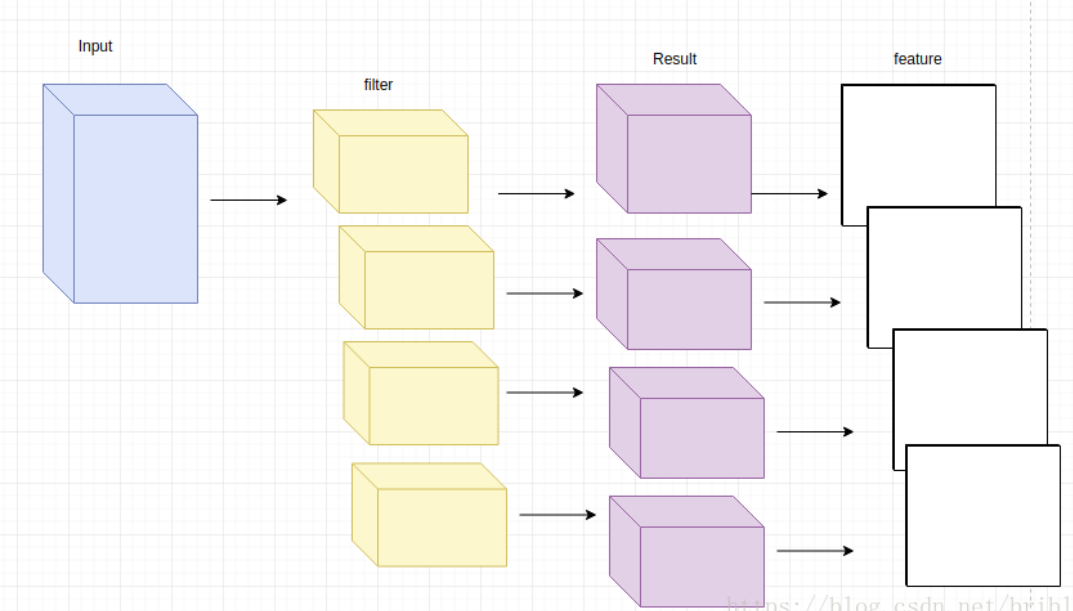

In [4]:
def corr2d_multi_in_out(X,K):
    #对K的第0维遍历，每次同输入X做互相关计算，
    #所有结果使用stack函数合并
    return torch.stack([corr2d_multi_in(X,k) for k in K])

In [5]:
#将核数组K同K+1（K中每个元素加一）和K+2连结在一起来构造一个输出通道数为3的卷积核。

K=torch.stack([K,K+1,K+2])
K.shape #3个3维卷积核

torch.Size([3, 2, 2, 2])

输入数组X与核数组K做互相关运算。此时的输出含有3个通道。其中第一个通道的结果与之前输入数组X与多输入通道、单输出通道核的计算结果一致。

In [8]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 5.3.3 1×1 卷积层

讨论卷积窗口形状为$1×1（k_h=k_w=1）$的多通道卷积层。我们通常称之为1×1卷积层，并将其中的卷积运算称为1×1卷积。因为使用了最小窗口，1×1卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，1×1卷积的主要计算发生在通道维上。图5.5展示了使用输入通道数为3、输出通道数为2的1×1卷积核的互相关计算。值得注意的是，输入和输出具有相同的高和宽。输出中的每个元素来自输入中在高和宽上相同位置的元素在不同通道之间的按权重累加。假设我们将通道维当作特征维，将高和宽维度上的元素当成数据样本，那么<font color='red'>1×1卷积层的作用与全连接层等价</font>。

* 有几个卷积核就有几个输出通道
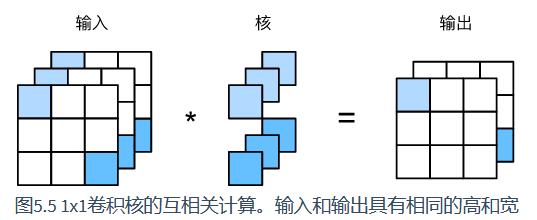

In [17]:
# 使用全连接层中的矩阵乘法来实现1×1卷积。
# 这里需要在矩阵乘法运算前后对数据形状做一些调整。

def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w=X.shape #c_i为输入通道
    c_o=K.shape[0] #输出通道数=卷积核的个数
    X=X.view(c_i,h*w)#变为c_i个一维向量
    K=K.view(c_o,c_i)#输出通道数，输入通道数
    Y=torch.mm(K,X)#全连接层的矩阵乘法
    return Y.view(c_o,h,w)

In [19]:
# 做1×1卷积时，
# 以上函数与之前实现的互相关运算函数corr2d_multi_in_out等价。

X=torch.rand(3,3,3)
K=torch.rand(2,3,1,1)

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1-Y2).norm().item()<1e-6

True

1×1卷积层被当作保持高和宽维度形状不变的全连接层使用。于是，我们可以通过调整网络层之间的通道数来控制模型复杂度。